In [84]:
import os
import json
import bisect
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

import ipywidgets as widgets
from IPython.display import display, HTML

%matplotlib inline

pd.set_option('mode.chained_assignment', None)

In [86]:
basedir = Path("data")
dirs = [entry.name for entry in basedir.iterdir() if entry.is_dir()]
dd = widgets.Dropdown(
    options=sorted(dirs),
    description='Directory:'
)
display(dd)

Dropdown(description='Directory:', options=('BT', 'BT_bigLR_lowEpsDec', 'BT_bigRounds_eqPriExps', 'BT_bigRound…

In [96]:
path = basedir / dd.value
metadata_files = []
data_files = []
for f in path.iterdir():
    file_name = f.name
    if file_name.endswith(".json"):
        metadata_files.append(file_name)
    elif file_name.endswith(".csv"):
        data_files.append(file_name)
    else:
        print("Cannot classify file: ", file_name)

In [97]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data, dtype=float)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m, m+h

In [98]:
runs = 1
metadata = {}
for file_name in metadata_files:
    base = file_name.split(".")[0]
    num = int(base.split("_")[-1])
    runs = max(runs, num)
    with open(path / file_name) as f:
        metadata[num] = json.load(f)

display(pd.DataFrame(metadata[1]["characters_info"]))

,Goblin1,Goblin2
type,Goblin,Goblin
network_id,Goblin1_1,Goblin2_1
team,team1,team2
speed,120,120
weight,1,1
max_life,30,30
damage,10,10
defense,0,0
controller_type,1,1
controller_name,Single QL,Basic BT


In [99]:
chars = set()
data_sets = {}
replay_times = {}
terminal_times = {}

def get_round(times_array):
    def f(time):
        return bisect.bisect_left(times_array, time)
    return f

def get_round_time(times_array):
    def f(time):
        idx = bisect.bisect_left(times_array, time)
        if idx == 0:
            return time
        begin_time = times_array[idx - 1]
        return time - begin_time
    return f

for file_name in data_files:
    base = file_name.split(".")[0]
    split_res = base.split("_")
    run = int(split_res[-1])
    char = split_res[-2]
    chars.add(char)
    print("-----", run, " ", char, "-----")
    
    data = pd.read_csv(path / file_name)
    
    if data_sets.get(run) is None:
        data_sets[run] = {}
        replay_times[run] = {}

    data_sets[run][char] = data
    print("data size: ", data.shape)
    
    replays = sorted(data[data["replay"] == True]["time"].value_counts().keys().tolist())
    replay_times[run][char] = replays
    print("replays: ", len(replays))
    
    terminal_data = data[data["terminal"] == True]
    terminal_count = terminal_data[terminal_data["replay"] == False]["time"].value_counts()
    print(set(terminal_count))
    terminals = sorted(terminal_count.keys().tolist())
    terminal_times[run] = terminals
    print("terminals: ", len(terminals))
    
    discount = metadata[run]["characters_info"][char]["discount"]
    data["label"] = data["reward"] + discount * data["next_val"] * (~ data["terminal"])
    data["loss"] = (data["label"] - data["q_val"])**2
    data["round"] = data["time"].map(get_round(replays))
    data["round_time"] = data["time"].map(get_round_time(replays))
    
chars = sorted(list(chars))
print(chars)
num_chars = len(chars)

----- 10   Goblin1 -----
data size:  (174573, 28)
replays:  166
{1}
terminals:  180
----- 6   Goblin1 -----
data size:  (174638, 28)
replays:  163
{1}
terminals:  180
----- 8   Goblin1 -----
data size:  (170120, 28)
replays:  161
{1}
terminals:  180
----- 1   Goblin1 -----
data size:  (187653, 28)
replays:  173
{1}
terminals:  180
----- 4   Goblin1 -----
data size:  (176471, 28)
replays:  168
{1}
terminals:  180
----- 9   Goblin1 -----
data size:  (185359, 28)
replays:  172
{1}
terminals:  180
----- 2   Goblin1 -----
data size:  (181065, 28)
replays:  168
{1}
terminals:  180
----- 7   Goblin1 -----
data size:  (182163, 28)
replays:  170
{1}
terminals:  180
----- 3   Goblin1 -----
data size:  (186158, 28)
replays:  172
{1}
terminals:  180
----- 5   Goblin1 -----
data size:  (182102, 28)
replays:  170
{1}
terminals:  180
['Goblin1']


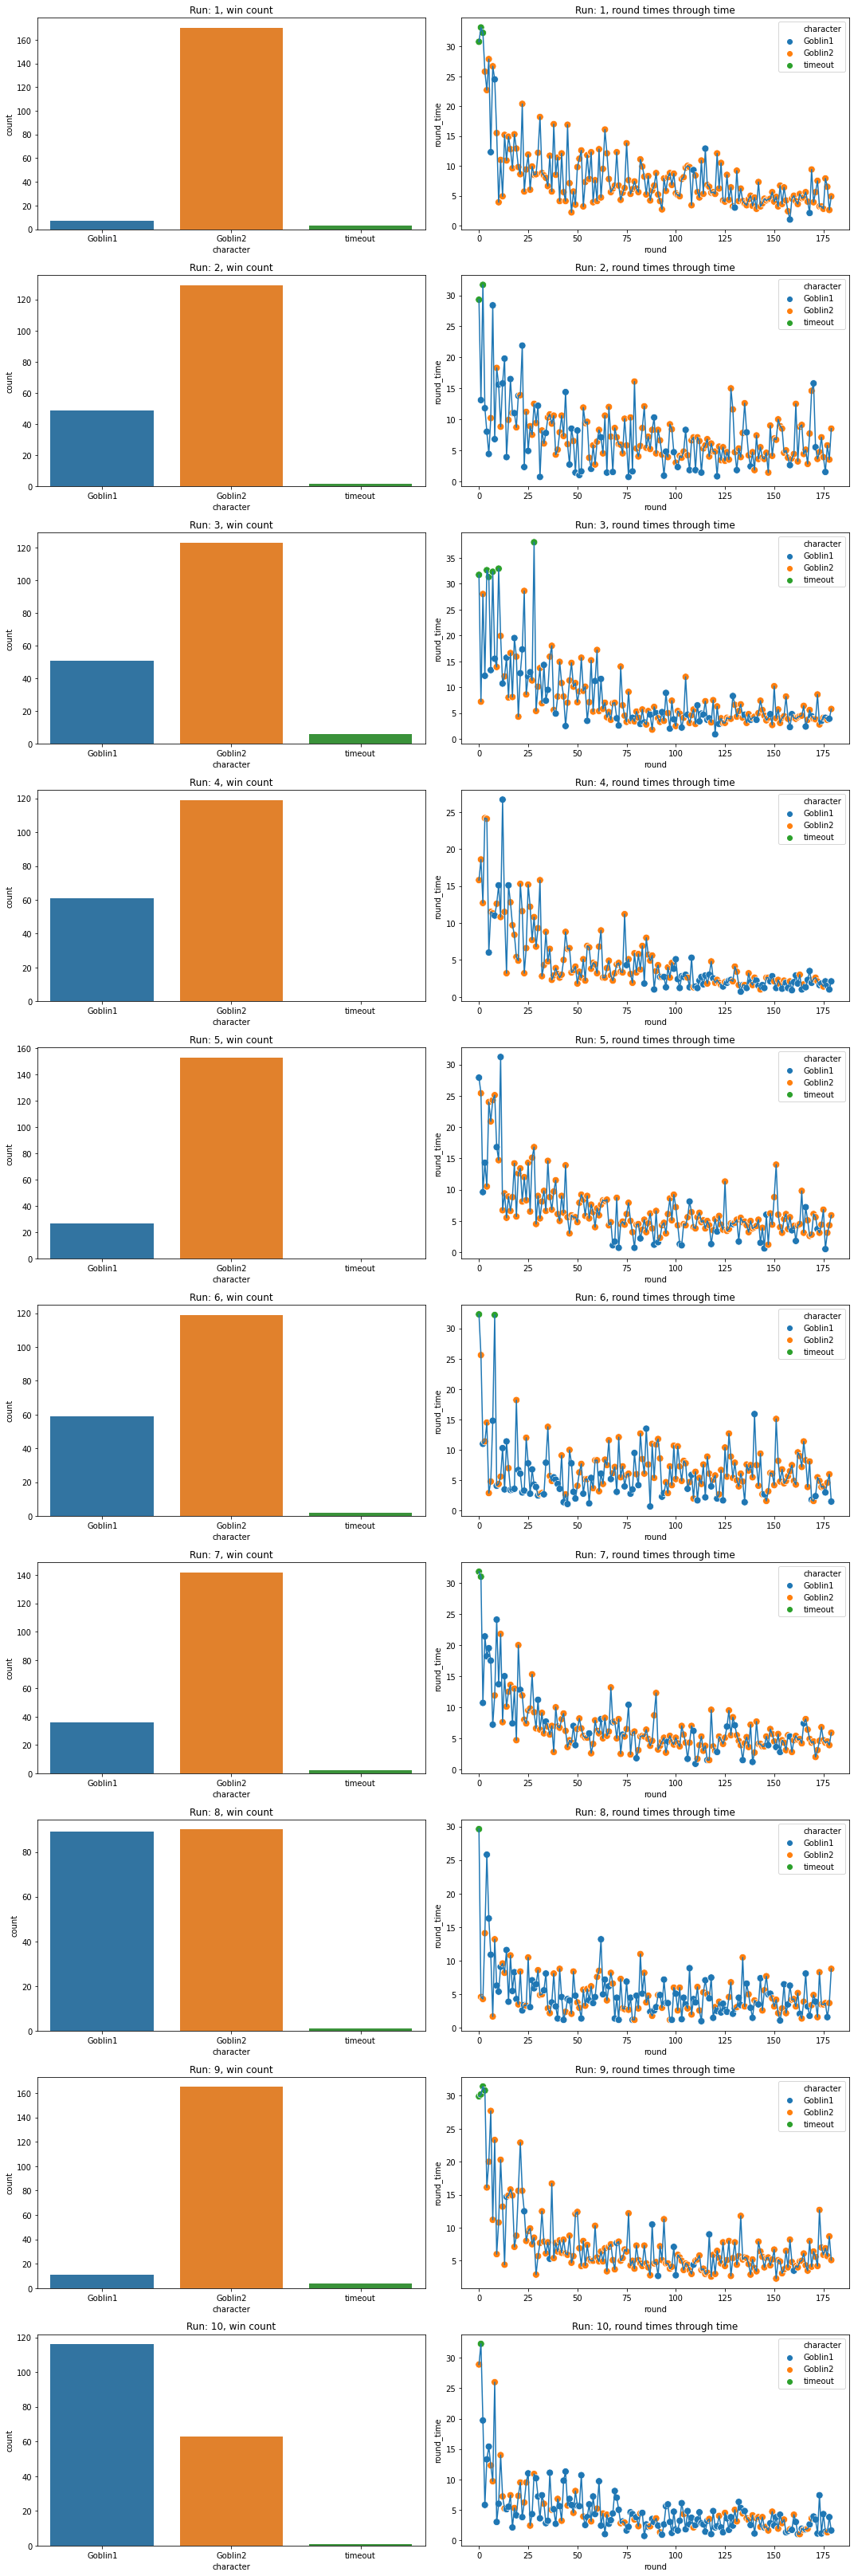

In [100]:
# Gráficos mostrando histograma de vitórias

order = sorted(["timeout"] + list(metadata[1]["characters_info"].keys()))
fig, ax = plt.subplots(runs, 2, figsize=(15, 4.5 * runs))
for run in range(runs):
    ax[run][0].set_title(f"Run: {run + 1}, win count")
    winners = metadata[run + 1]["winners"]
    winners_table = pd.DataFrame({"time": terminal_times[run + 1], "character": winners}).reset_index().rename(columns={"index": "round"})
    winners_table["round_time"] = winners_table["time"] - winners_table["time"].shift(1)
    winners_table["round_time"][0] = winners_table["time"][0]
    winners_table = winners_table.iloc[0:len(terminal_times[run + 1])]
    sns.countplot(x="character", data=winners_table, order=order, ax=ax[run][0])
    ax[run][1].set_title(f"Run: {run + 1}, round times through time")
    sns.lineplot(x="round", y="round_time", data=winners_table, ax=ax[run][1])
    sns.scatterplot(x="round", y="round_time", hue="character", hue_order=order, s=80, data=winners_table, ax=ax[run][1])
    
plt.tight_layout()
plt.show()

In [103]:
# Tabela com as estatísticas dos gráficos da célula anterior
win_rates = {c: [] for c in chars}
mean_round_times = {c: [] for c in chars}
std_round_times = {c: [] for c in chars}
num_exploit_rounds = []
chars_info = metadata[1]["characters_info"]
num_rounds = metadata[1]["rounds"]
min_time = max([info["exploration_rate_decay_time"] for info in chars_info.values()])

for run in range(runs):
    run_metadata = metadata[run + 1]
    run_data = data_sets[run + 1]
    winners = run_metadata["winners"]
    for c in chars:
        data = run_data[c]
        terminal_states = data[(data["replay"] == False) & (data["terminal"] == True)]
        exploit_rounds = terminal_states[terminal_states["time"] > min_time]
        num_exploit_rounds.append(len(exploit_rounds))
        if len(exploit_rounds) == 0:
            mean_round_times[c].append(-1)
            std_round_times[c].append(-1)
            win_rates[c].append(-1)
            continue
        round_times = (exploit_rounds["time"] - exploit_rounds["time"].shift(1)).shift(-1)
        mean_round_times[c].append(round_times.mean())
        std_round_times[c].append(round_times.std())
        char_winners = pd.DataFrame({"time": terminal_states["time"].to_list(), "character": winners})
        char_winners = char_winners[char_winners["time"] > min_time]
        counts = char_winners["character"].value_counts()
        win_rates[c].append(counts.get(c, 0.0) / counts.sum())

stats_table = {"num_exploit_rounds": num_exploit_rounds}
confidence_intervals = {"win_rate": {}}
for c in chars:
    valid_win_rates = [r for r in win_rates[c] if r != -1.0]
    win_rate_interval = "({:.4f}, {:.4f}, {:.4f})".format(*mean_confidence_interval(valid_win_rates))
    confidence_intervals["win_rate"][c] = win_rate_interval
    stats_table[c + "_win_rate"] = win_rates[c]
    stats_table[c + "_mean_round_times"] = mean_round_times[c]
    stats_table[c + "_std_round_times"] = std_round_times[c]
display(pd.DataFrame(stats_table))
display(pd.DataFrame(confidence_intervals))

,num_exploit_rounds,Goblin1_win_rate,Goblin1_mean_round_times,Goblin1_std_round_times
0,112,0.044643,5.938739,2.507885
1,91,0.186813,5.585556,3.070540
2,123,0.284553,4.960656,2.386448
3,25,0.680000,1.920833,0.654735
4,87,0.172414,4.723256,2.204683
5,63,0.158730,5.820968,3.093734
6,90,0.166667,4.607865,1.739202
7,29,0.344828,3.892857,2.084853
8,102,0.068627,5.265347,1.962521
9,24,0.708333,2.478261,1.536216


,win_rate
Goblin1,"(0.1137, 0.2816, 0.4494)"


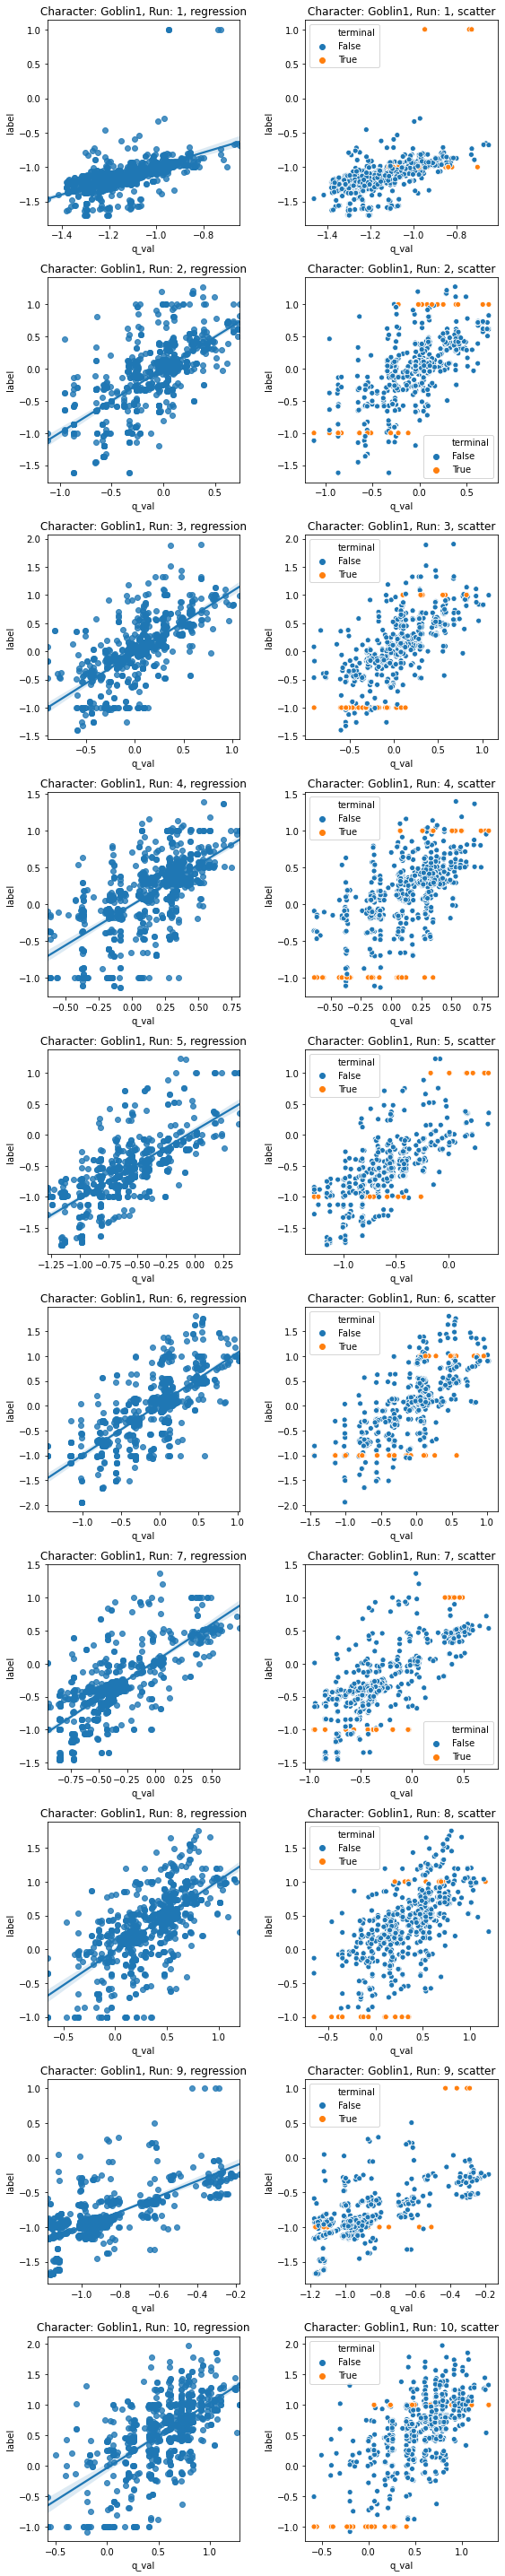

In [104]:
# Gráficos mostrando relação q-val x label no último replay

fig, ax = plt.subplots(runs, 2 * num_chars, figsize=(8 * num_chars, 4 * runs))
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][2 * j + 0].set_title(f"Character: {char}, Run: {i}, regression")
        ax[i - 1][2 * j + 1].set_title(f"Character: {char}, Run: {i}, scatter")
        data = data_sets[i][char]
        last_replay_time = replay_times[i][char][-1]
        this_time_data = data[data["time"] == last_replay_time]
        sns.regplot(x="q_val", y="label", data=this_time_data, ax=ax[i - 1][2 * j + 0])
        sns.scatterplot(x="q_val", y="label", hue="terminal", data=this_time_data, ax=ax[i - 1][2 * j + 1])
plt.tight_layout()
plt.show()

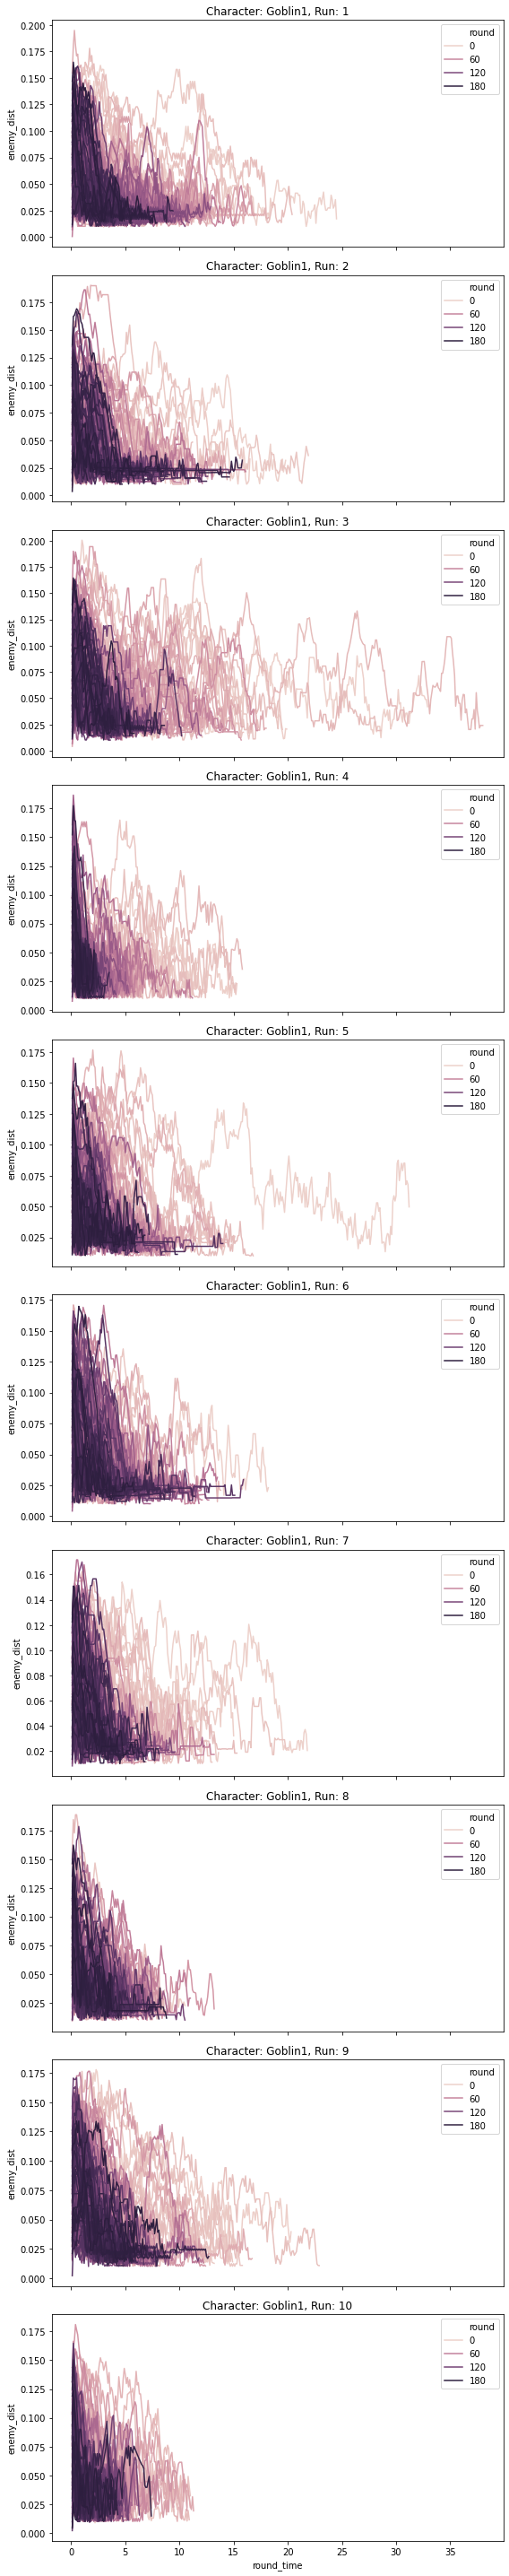

In [105]:
# Gráficos mostrando evolução da distância da IA ao inimigo conforme o tempo, com hue = número do round

fig, ax = plt.subplots(runs, num_chars, figsize=(8 * num_chars, 4 * runs), squeeze=False, sharex=True)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][j].set_title(f"Character: {char}, Run: {i}")
        data = data_sets[i][char]
        data = data[(data["replay"] == False) & (data["round"] != 0)]
        sns.lineplot(x="round_time", y="enemy_dist", hue="round", data=data, ax=ax[i - 1][j])
plt.tight_layout()
plt.show()

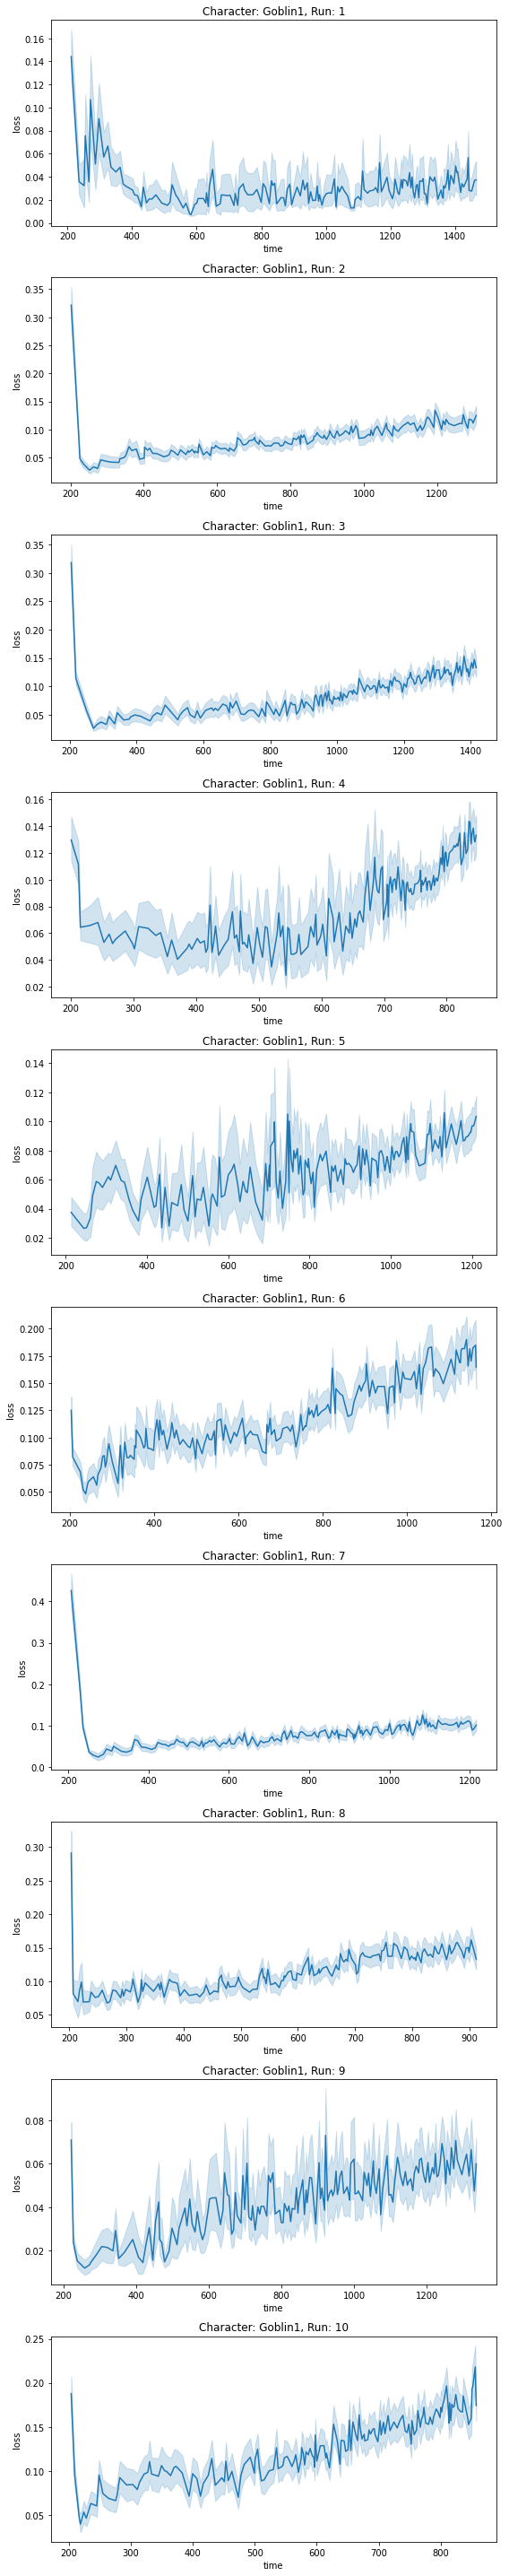

In [106]:
# Comparação da função de perda

fig, ax = plt.subplots(runs, num_chars, figsize=(8 * num_chars, 4 * runs), squeeze=False)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][j].set_title(f"Character: {char}, Run: {i}")
        data = data_sets[i][char]
        data = data[data["replay"] == True]
        sns.lineplot(x="time", y="loss", data=data, ax=ax[i - 1][j])
plt.tight_layout()
plt.show()

In [65]:
# Mostrar com várias bolinhas no 2D quando foi que aconteceram eventos de perda de vida